## Pycytominer example pipeline
requires scipy=<1.7.3


### TODO: 
* Import all data and save intermediate steps.
* Pot grit scores, percent replicating.
* PCA of the dmso of different cell lines. 

#### Thought
* More restrictive preprocessing of the data does not do so much.

In [37]:
import os
import numpy as np
import pandas as pd
import string

# pycytominer
from pycytominer import aggregate
from pycytominer import annotate
from pycytominer import consensus
from pycytominer import feature_select
from pycytominer import normalize

# Import these for plotting
import umap.umap_ as umap
import umap.plot
from matplotlib.text import Text
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")
%matplotlib inline
from sklearn.decomposition import PCA
from cytominer_eval import evaluate

# Set current working directory
print(os.getcwd())
os.chdir('../maxproject_features/')
print(os.getcwd())



/share/data/analyses/christa/colopaint3D/maxproject_features
/share/data/analyses/christa/colopaint3D/maxproject_features


In [38]:
OutputDir = "results" # Where do you want to save the merged data csv? 
if not os.path.exists(OutputDir):
    os.makedirs(OutputDir)

### Perfrom quality control



In [39]:
### Some settings

features = ['ImageQuality_PowerLogLogSlope_PHAandWGA', 'ImageQuality_PowerLogLogSlope_HOECHST', 'ImageQuality_PowerLogLogSlope_CONC','ImageQuality_PowerLogLogSlope_SYTO', 'ImageQuality_PowerLogLogSlope_MITO']
cells = ["HCT116", "HT29", "DLD1", "HCT15"]

cutoff = 0.93

In [40]:
# Initialize the dataframe
QC = pd.DataFrame()

for cell_line in cells:
    # Import QC for all cell lines 
    QCfile = "/share/data/cellprofiler/automation/results/spher010/MaxProjections/{}/QC/qcRAW_images.csv".format(cell_line)

    # Import the data
    data = pd.read_csv(QCfile, index_col=0)
    data['cell_line'] = cell_line

    data['flag'] = 0
    for feature in features: 
        data['flag'] = data['flag'] + (data[feature] > data[feature].quantile(cutoff)).astype(int)

    # Merge the data
    QC = pd.concat([QC, data])
    

# Update the source layout to match the new well assignments 
QC['well'] = QC['FileName_CONC'].str.split('-', expand=True)[1]
QC['well_number'] = QC['well'].str.split('(\d+)', expand=True)[1].str.lstrip('0').astype(int)
QC['well_letter'] = QC['well'].str.split('(\d+)', expand=True)[0].map(lambda x: ord(x) - 64)

QC['plate_well'] = QC['well'] + "_" + QC['cell_line']
# Save the merged data
# QC.to_csv("{}/{}.csv".format(OutputDir, cell_line), index=False)

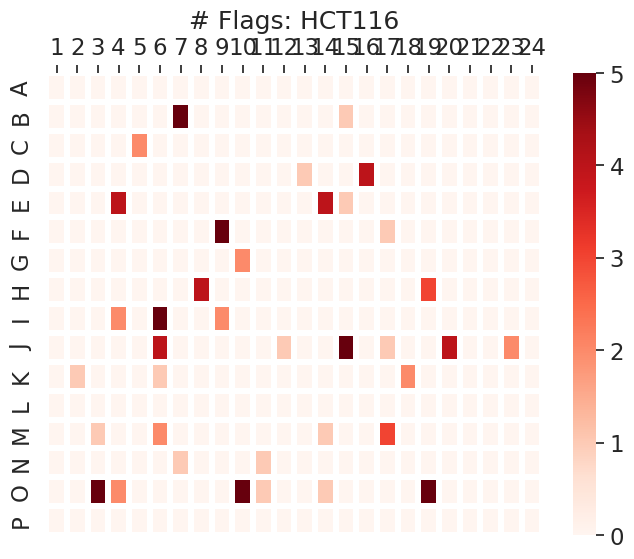

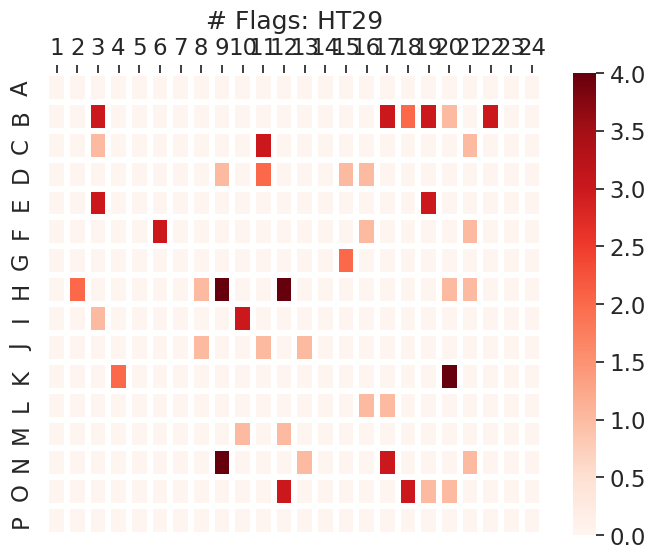

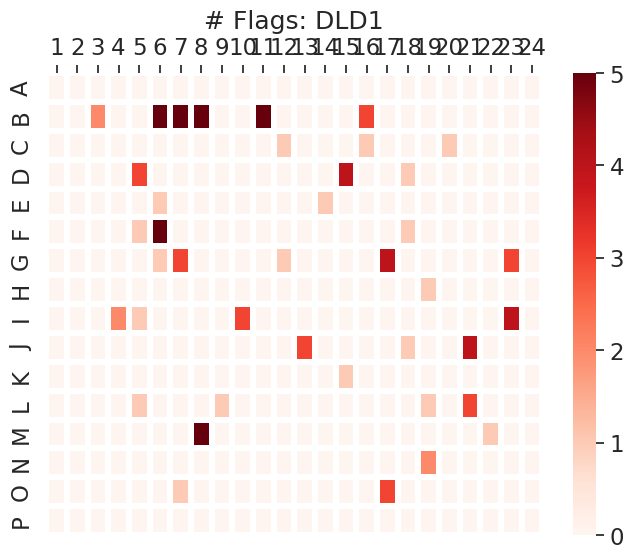

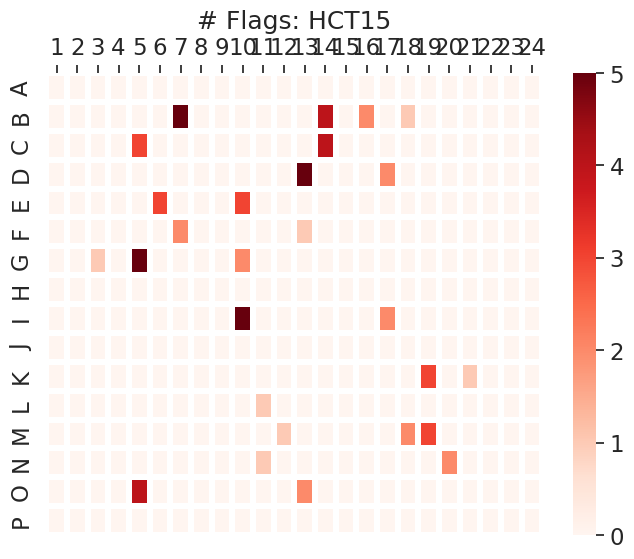

In [41]:
## Quick QC

for cell_line in cells:

    # define a 386-well plate
    cols = 24
    rows = 16

    heatmap = np.zeros((rows,cols))

    plot_df = QC[QC['cell_line'] == cell_line]

    for i in range(len(plot_df)):
        heatmap[plot_df['well_letter'].iloc[i]-1,plot_df['well_number'].iloc[i]-1] = plot_df['flag'].iloc[i]

    plt.figure(figsize=(8,6))

    %matplotlib inline
    yticklabels= list(string.ascii_uppercase)[:16]
    xticklabels = range(1, 25)

    ax = sns.heatmap(heatmap, linewidths=3, cmap='Reds', yticklabels=yticklabels, xticklabels=xticklabels)
    ax.set_title('# Flags: {}'.format(cell_line))
    ax.xaxis.tick_top()


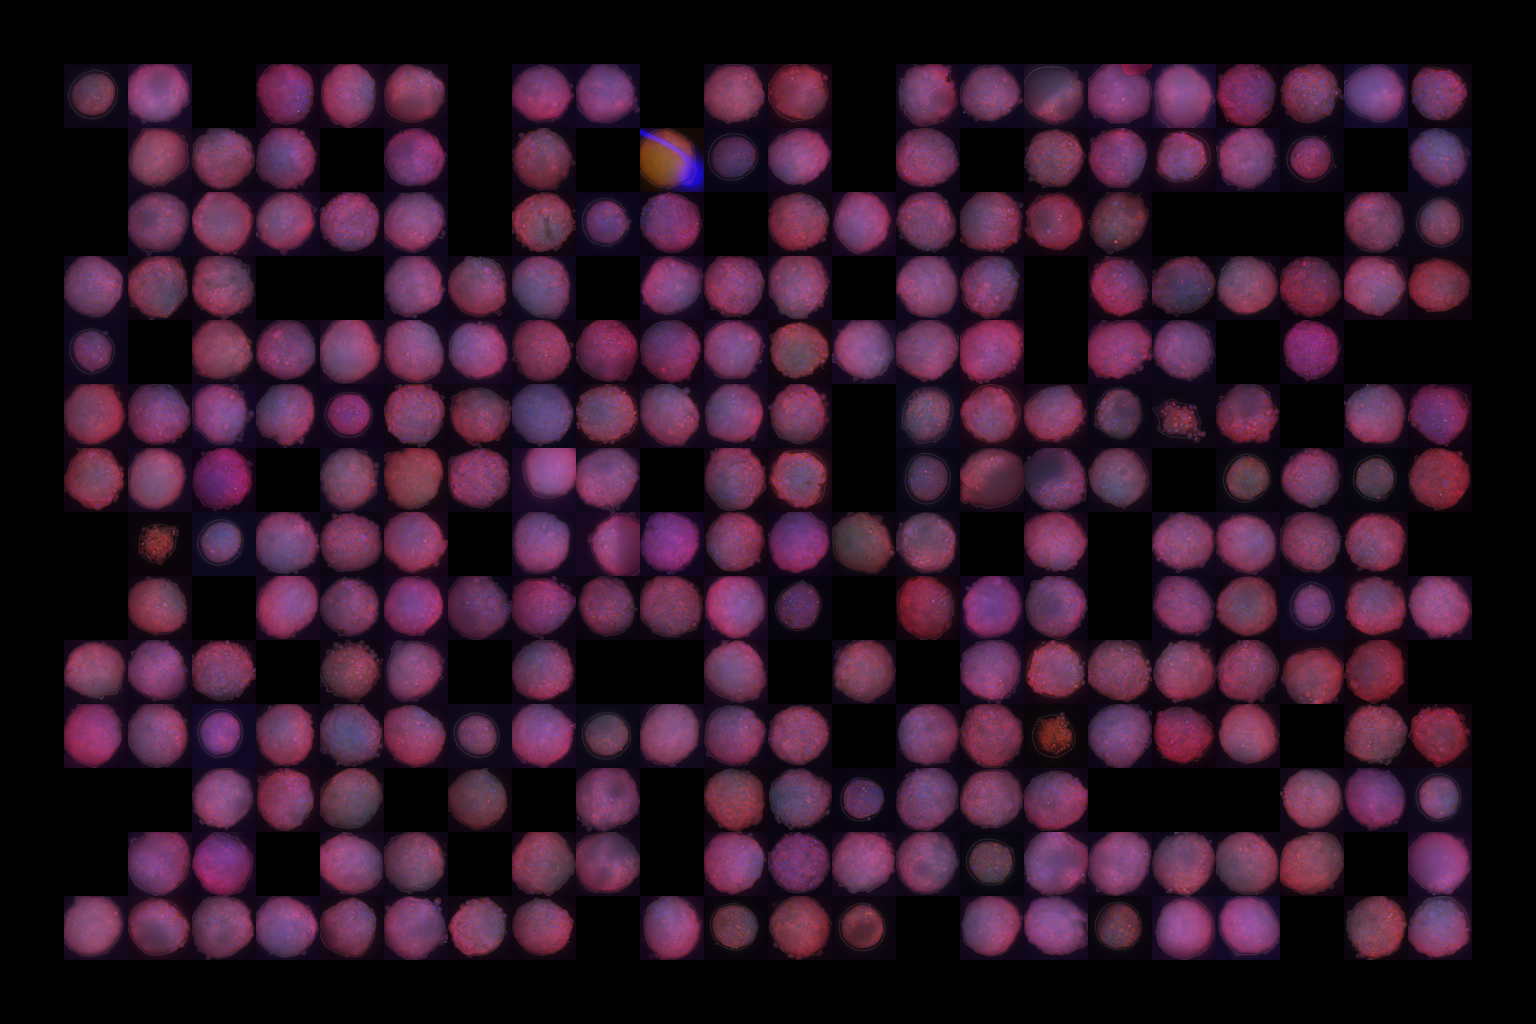

In [42]:
from PIL import Image

## Create a montage of all images

cell_line = "HT29"

n = 64
# n= 512

dir = ("/share/data/cellprofiler/automation/results/spher010/MaxProjections/{}/img/segmentation/".format(cell_line))

# List files in the directory with the .png extension
files = [f for f in os.listdir(dir) if f.endswith('.png')]

# string split the name with '_' and take the third part
# this will be the well name
wells = [f.split('_')[2] for f in files]



# Convert the well names and paths to a pandas dataframe
images = pd.DataFrame({'well_id': wells, 'name': files, 'cell_line': cell_line, 'path': [dir + f for f in files]})
#Drop well_id that are Nan
images = images[~(images['well_id'] == 'None')]

images['well_number'] = images['well_id'].str.split('(\d+)', expand=True)[1].str.lstrip('0').astype(int)
images['well_letter'] = images['well_id'].str.split('(\d+)', expand=True)[0].map(lambda x: ord(x) - 64)

montage = Image.new('RGB', (cols*n, rows*n))

for i in range(len(images)):
    well = images['well_id'].iloc[i]
    img = Image.open("/share/data/cellprofiler/automation/results/spher010/MaxProjections/{}/img/segmentation/spheroid_segmented_{}_None.png".format(cell_line, well))
    img = img.resize((n, n))
    montage.paste(img, ((images['well_number'].iloc[i]-1)*n, (images['well_letter'].iloc[i]-1)*n))

display(montage)


### Preprocess with pycytominer

In [43]:
## Import data and remove QC flags

data = pd.DataFrame()

for cell_line in cells:
    # Import QC for all cell lines 
    data_file = "/share/data/cellprofiler/automation/results/spher010/MaxProjections/{}/results/featICF_spheroid.csv".format(cell_line)

    # Import the data
    tmp= pd.read_csv(data_file, index_col=0)
    tmp['cell_line'] = cell_line

    print("Data", cell_line ,":\n", tmp.shape)

    # Merge the data
    data = pd.concat([data, tmp])
    print("XXX", data.shape)

# Rename the plate_well using Metadata_barcode and well_id
data['plate_well'] = data['Metadata_Well'] + "_" + data['cell_line']

df = data.merge(QC[['plate_well', 'well', 'flag']], left_on=['plate_well'], right_on=['plate_well'])

print("Data before QC:\n", df.shape)

# Filter out wells with 2 or more flags
df = df[df['flag'] < 2]

print("Data after QC:\n", df.shape, "\n")


## Are there any NaNs? 
nans = df.isna().sum()
nans = nans[nans > 0]

print("There are so many nans:\n", nans)

Data HCT116 :
 (264, 738)
XXX (264, 738)
Data HT29 :
 (241, 738)
XXX (505, 738)
Data DLD1 :
 (270, 738)
XXX (775, 738)
Data HCT15 :
 (192, 738)
XXX (967, 738)
Data before QC:
 (966, 741)
Data after QC:
 (882, 741) 

There are so many nans:
 Metadata_Channel         882
Metadata_Channel.1       882
Metadata_FileLocation    882
dtype: int64


In [44]:
# # Create a Metadata_Well from the Filename
# df["Metadata_well_id"] = df["FileName_CONC"].str.split("_").str[-1].str.split(".").str[0]

# Remove non-data features from the list of features
ListOfFeatures = list(df.columns.values)
ListOfMetadata = list(df.columns[
    df.columns.str.contains("FileName_") |
    df.columns.str.contains("PathName_") |
    df.columns.str.contains("Metadata_")])
ListOfFeatures = list(set(ListOfFeatures) - set(ListOfMetadata) - set(['ObjectNumber', 'Number_Object_Number', 'well', 'flag']))

# ListOfMetadataNew = ["Metadata_Well", "cell_line"] 

# Remove all metadata, paths and filenames except for the well_id
df = df[ListOfFeatures +  ["Metadata_Well"]]

In [45]:
# Import Metadata
dfLayout = pd.read_csv('spher010-metadata.csv', sep=",")
dfLayout = dfLayout.loc[~(dfLayout.layout_id == 'spher010-P1-L2')]
# Rename the plate_well using Metadata_barcode and well_id
dfLayout['plate_well'] = dfLayout['well_id'] + "_" + dfLayout['cell_line']
print(dfLayout.shape)
dfLayout.head()

(1216, 18)


,Metadata_Barcode,layout_id,image_id,cp_id,well_id,plate_well,cmpdname,cmpd,solvent,stock_conc,stock_conc_unit,cmpd_vol,cmpd_vol_unit,pert_type,cmpd_conc,cmpd_conc_unit,moa,cell_line
304,spher010-HCT15-L2,spher010-P1-L3,3954,5246.0,B02,B02_HCT15,tetr,spher007,dmso,10,mM,0.012,µL,poscon,3.0,uM,calcium channel blocker,HCT15
305,spher010-HCT15-L2,spher010-P1-L3,3954,5246.0,B03,B03_HCT15,fenb,spher002,dmso,1,mM,0.040,µL,poscon,1.0,uM,tubulin beta chain,HCT15
306,spher010-HCT15-L2,spher010-P1-L3,3954,5246.0,B04,B04_HCT15,IWR-1,spher010,dmso,10,mM,0.040,µL,poscon,10.0,uM,WNT / beta-catenin inhibitor,HCT15
307,spher010-HCT15-L2,spher010-P1-L3,3954,5246.0,B05,B05_HCT15,fenb,spher002,dmso,1,mM,0.040,µL,poscon,1.0,uM,tubulin beta chain,HCT15
308,spher010-HCT15-L2,spher010-P1-L3,3954,5246.0,B06,B06_HCT15,stau,spher008,dmso,1,mM,0.008,µL,poscon,0.2,uM,pan protein inhibitor,HCT15


In [46]:
# Annotate: connect metadata to the feature data
# OBS: metadata will be prefixed with 'Metadata_'
annotated = annotate(df, platemap=dfLayout, join_on=['Metadata_plate_well', 'plate_well'],add_metadata_id_to_platemap=True, format_broad_cmap=False, clean_cellprofiler=False)
# annotated.to_csv("{}/annotated_data_{}.csv".format(OutputDir, cell_line))

annotated.shape

(867, 738)

In [47]:
# Remove non-data features from the list of features
ListOfFeatures = list(df.columns.values)
ListOfMetadata = list(df.columns[df.columns.str.contains("Metadata_")])
ListOfFeatures = list(set(ListOfFeatures) - set(ListOfMetadata) - set(["plate_well", "cell_line"]))

In [48]:
#
# Version 2: Normalize separately per 1) plate
#

# # Normalize separately per cell line
# ListOfPlates = annotated['Metadata_layout_id'].unique()

# itnitialize an empty dataframe
normalized = pd.DataFrame(columns=annotated.columns.values)
normalized = normalized.drop(columns=['plate_well', 'cell_line'])

for cell_line in cells:
    
    # Normalize: choose between standardize, robustize, mad_robustize, spherize 
    normalized_temp = normalize(annotated[annotated['Metadata_cell_line'] == cell_line], 
                                features=ListOfFeatures,image_features=False, 
                                meta_features="infer", samples="Metadata_pert_type == 'negcon'", 
                                method="standardize")
    normalized = pd.concat([normalized, normalized_temp], ignore_index=True)

    print(cell_line)


HCT116
HT29
DLD1
HCT15


In [49]:
# # Normalize: choose between standardize, robustize, mad_robustize, spherize 
# normalized = normalize(annotated, features=ListOfFeatures,image_features=False, meta_features="infer", samples="Metadata_pert_type == 'negcon'", method="standardize")



In [50]:
# Feature selection: "variance_threshold", "correlation_threshold", "drop_na_columns", "blocklist", "drop_outliers", "noise_removal",
to_clip_df = feature_select(normalized, features=ListOfFeatures, operation=["variance_threshold", "correlation_threshold","drop_na_columns", "blocklist" ])

In [51]:
# Remove non-data features from the list
ListOfSelectedFeatures = list(to_clip_df.columns.values)
ListOfMetadata = list(to_clip_df.columns[to_clip_df.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

In [52]:
# Instead of removing the outliers, we can clip them to the 1st and 99th percentile.
selected_df = pd.concat([to_clip_df[ListOfMetadata], to_clip_df[ListOfSelectedFeatures].clip(lower=-40, upper=40, axis=1)], axis=1)
print(selected_df.shape)

(867, 451)


In [53]:
selected_df.to_csv("{}/selected_data.csv".format(OutputDir))

### Generate plots

In [54]:
df_toplot = selected_df[selected_df['Metadata_pert_type'] != 'trt'] # Only take positive controls

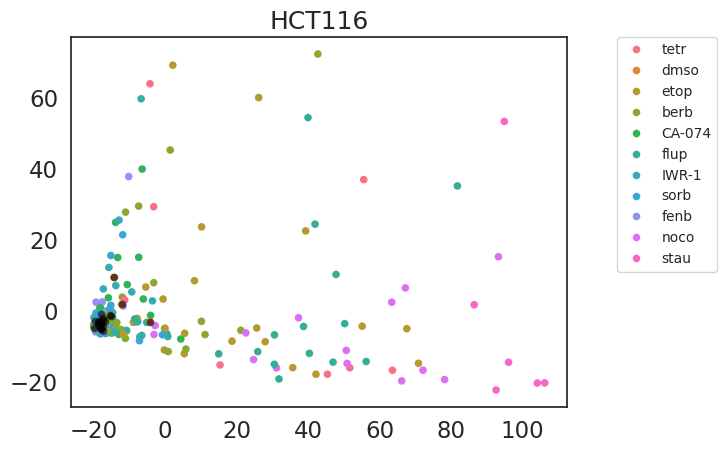

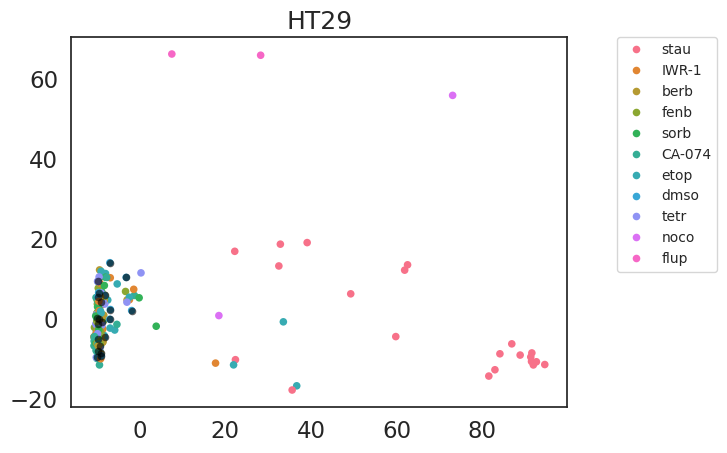

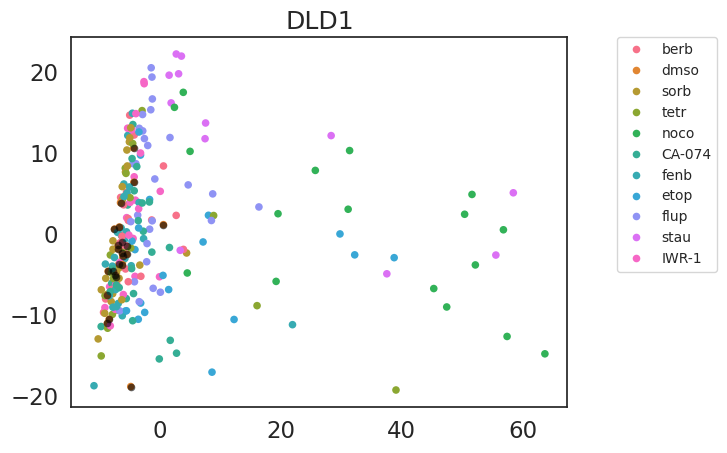

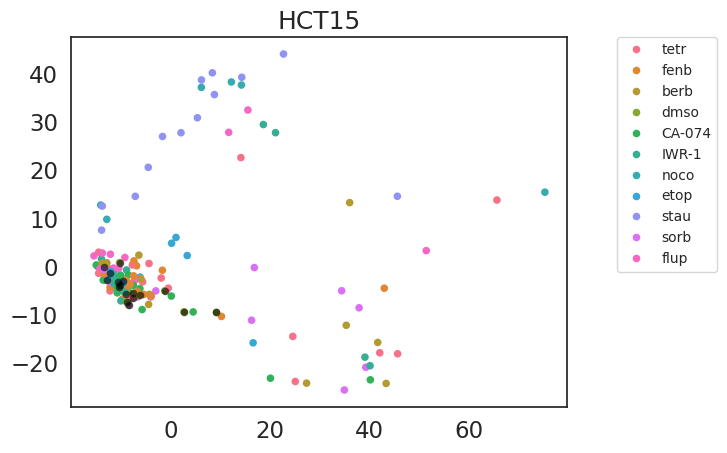

In [55]:
for cell_line in cells: 
    #PCA
    posconDf = df_toplot[df_toplot['Metadata_cell_line'] == cell_line]
    training_data = posconDf.loc[:, ListOfSelectedFeatures[:]].values

    reducer = umap.UMAP(n_components=8, n_neighbors=30, min_dist= 0.1, random_state=42)
    embedding = reducer.fit_transform(training_data)

    # Perform PCA
    pca = PCA(n_components=2)
    pca.fit(training_data)
    pca_embedding = pca.transform(training_data)

    fig = plt.figure()
    
    ax = sns.scatterplot(
    x=pca_embedding[:, 0],
    y=pca_embedding[:, 1],
    hue=posconDf.Metadata_cmpdname,
    alpha=1,
    linewidth=0,
    marker="o",
    s=30,
    )   

    ax = sns.scatterplot(
    x=pca_embedding[posconDf.Metadata_cmpdname == "dmso", 0],
    y=pca_embedding[posconDf.Metadata_cmpdname == "dmso", 1],
    # hue=posconDf.Metadata_cmpdname,
    c = 'black',
    alpha=0.6,
    linewidth=0,
    marker="o",
    s=30,
    )   

    ax.title.set_text(cell_line)
    ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.0, fontsize=10)
    # fig.savefig("{}/UMAP_{}_{}.png".format(OutputDir, title_str, cell_line), dpi=300)


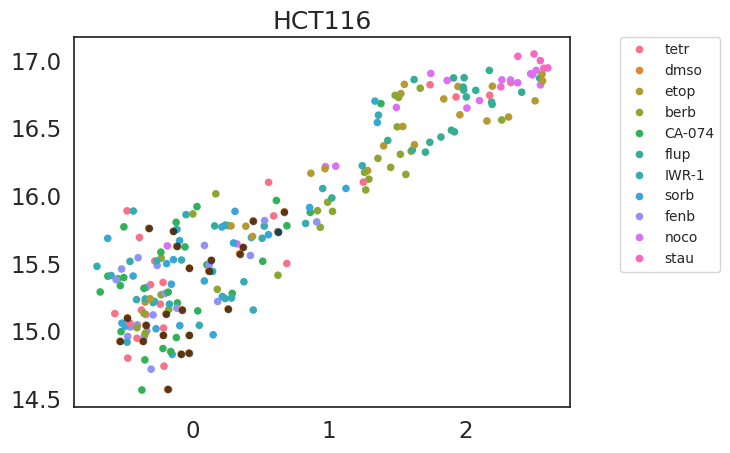

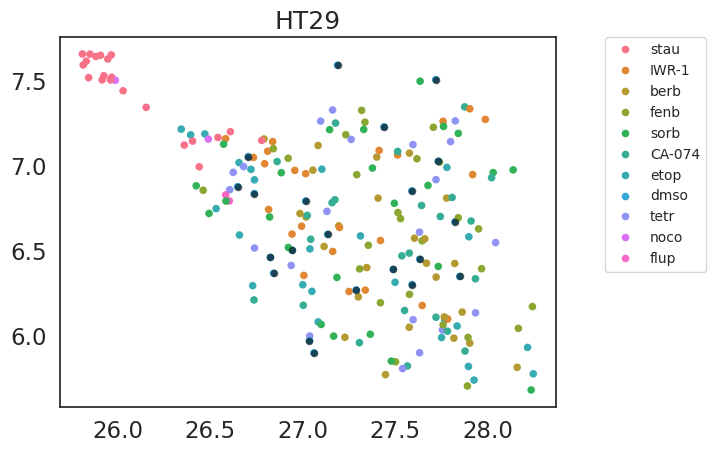

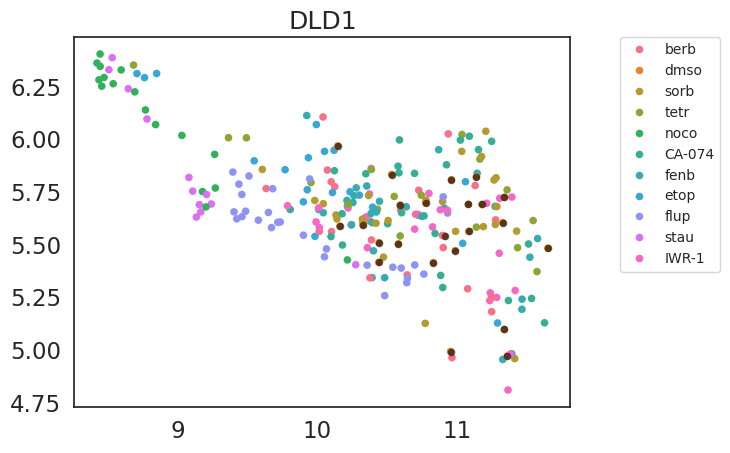

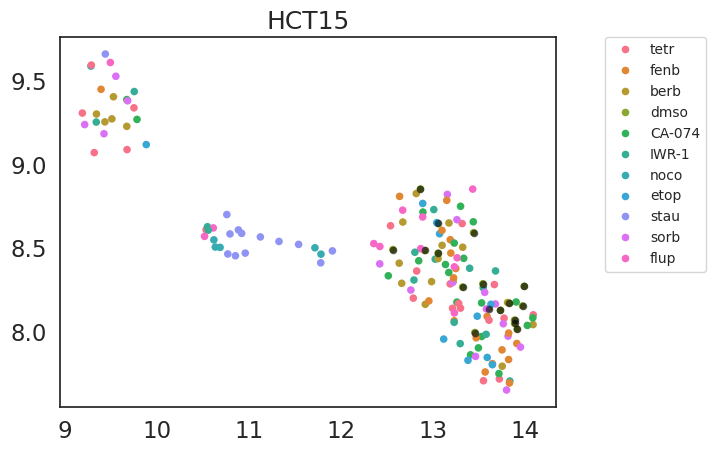

In [56]:
# UMAP

for cell_line in cells: 

    posconDf = df_toplot[df_toplot['Metadata_cell_line'] == cell_line]
    training_data = posconDf.loc[:, ListOfSelectedFeatures[:]].values

    reducer = umap.UMAP(n_components=8, n_neighbors=30, min_dist= 0.1, random_state=42)
    embedding = reducer.fit_transform(training_data)

    fig = plt.figure()
    
    ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=posconDf.Metadata_cmpdname,
    alpha=1,
    linewidth=0,
    marker="o",
    s=30,
    )   

    ax = sns.scatterplot(
    x=embedding[posconDf.Metadata_cmpdname == "dmso", 0],
    y=embedding[posconDf.Metadata_cmpdname == "dmso", 1],
    # hue=posconDf.Metadata_cmpdname,
    c = 'black',
    alpha=0.6,
    linewidth=0,
    marker="o",
    s=30,
    )   

    ax.title.set_text(cell_line)
    ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.0, fontsize=10)
    # fig.savefig("{}/UMAP_{}_{}.png".format(OutputDir, title_str, cell_line), dpi=300)

In [57]:
# Grit scores

for cell_line in cells:

    # Import data 
    # selected_df = pd.read_csv("{}/selected_data_{}.csv".format(BaseDir,cell_line), index_col=0)

    # Remove non-data features from the list
    ListOfSelectedFeatures = list(selected_df.columns.values)
    ListOfMetadata = list(selected_df.columns[selected_df.columns.str.contains("Metadata_")])
    ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

    dataset = selected_df.copy()
    dataset['Metadata_cell_line'].unique()

    dataset["Metadata_replicate_id"] = (
        dataset["Metadata_cmpdname"] + "_" + dataset.index.astype(str)
        ) 

    control_perts = dataset.query("Metadata_cmpdname == 'dmso' & Metadata_cmpd_conc == 0.1").Metadata_replicate_id.unique().tolist()
    grit_replicate_groups = {"profile_col": "Metadata_replicate_id", "replicate_group_col": "Metadata_cmpd_conc"}

    control_perts = dataset.query("Metadata_cmpdname == 'dmso' & Metadata_cmpd_conc == 0.1").Metadata_replicate_id.unique().tolist()
    grit_replicate_groups = {"profile_col": "Metadata_replicate_id", "replicate_group_col": "Metadata_cmpd_conc"}

    # Remove non-data features from the list
    ListOfSelectedFeatures = list(dataset.columns.values)
    ListOfMetadata = list(dataset.columns[dataset.columns.str.contains("Metadata_")])
    ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

    grit_scores = []

    # for cell_line in datasetPart.plate.unique():
    #    cell_line_df = datasetPart.query("plate == @cell_line")

    grit_results = evaluate(
        profiles=dataset,
        features=ListOfSelectedFeatures,
        meta_features=ListOfMetadata,
        replicate_groups=grit_replicate_groups,
        operation="grit",
        similarity_metric="pearson",
        grit_replicate_summary_method="median",
        grit_control_perts=control_perts,
    )  # .assign(cell_line=cell_line)

    grit_scores.append(grit_results)

    grit_scores = pd.concat(grit_scores).reset_index(drop=True)
    grit_scores["Metadata_cmpdname"] = grit_scores["perturbation"].str.split("_").str[0]
    grit_scores["Metadata_cmpd_conc"] = grit_scores["group"]
    grit_scores.Metadata_cmpd_conc = grit_scores.Metadata_cmpd_conc.astype(float)
    grit_scores.tail(9)

    # Add back the well information
    grit_scores = pd.merge(grit_scores,dataset[['Metadata_well_id', 'Metadata_cell_line', 'Metadata_replicate_id']], left_on='perturbation', right_on='Metadata_replicate_id')

    # grit_scores.to_csv("{}/grit_scores_{}.csv".format(BaseDir,cell_line))


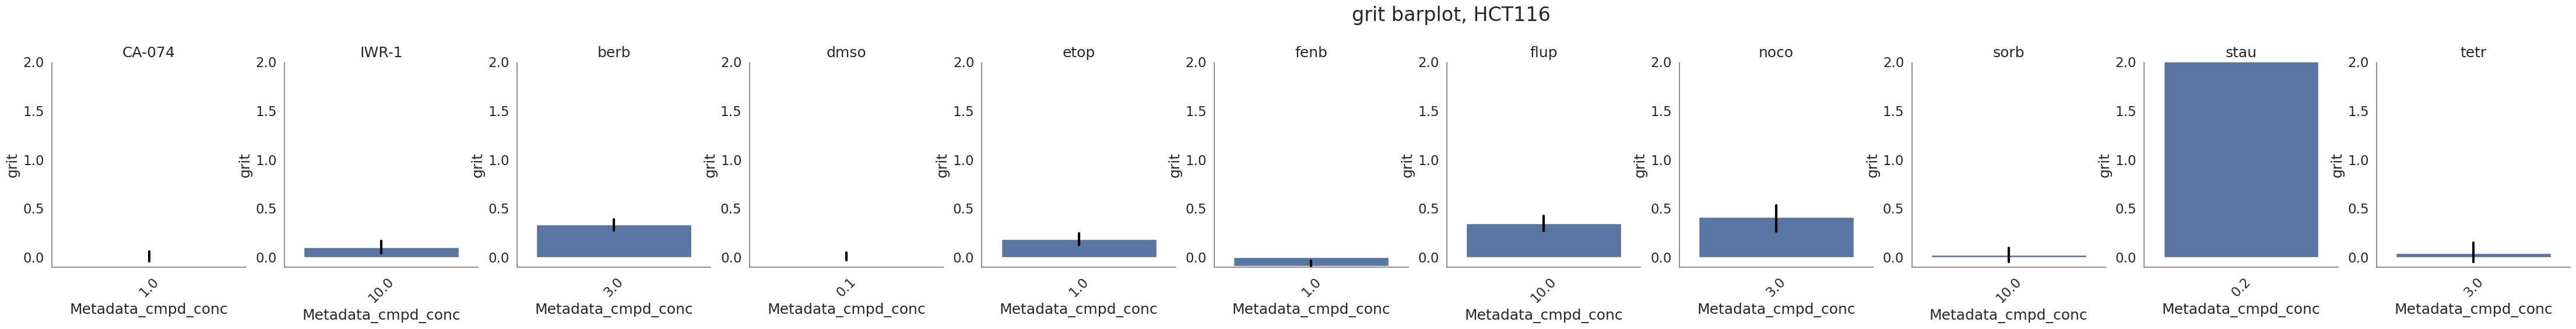

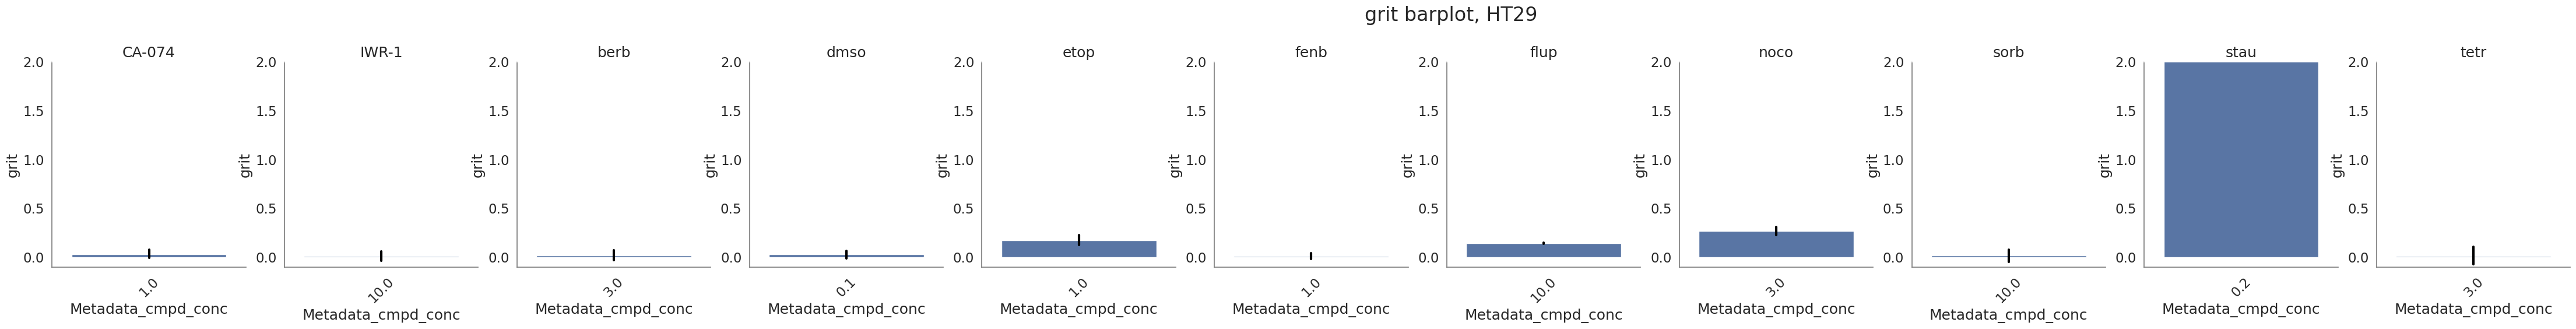

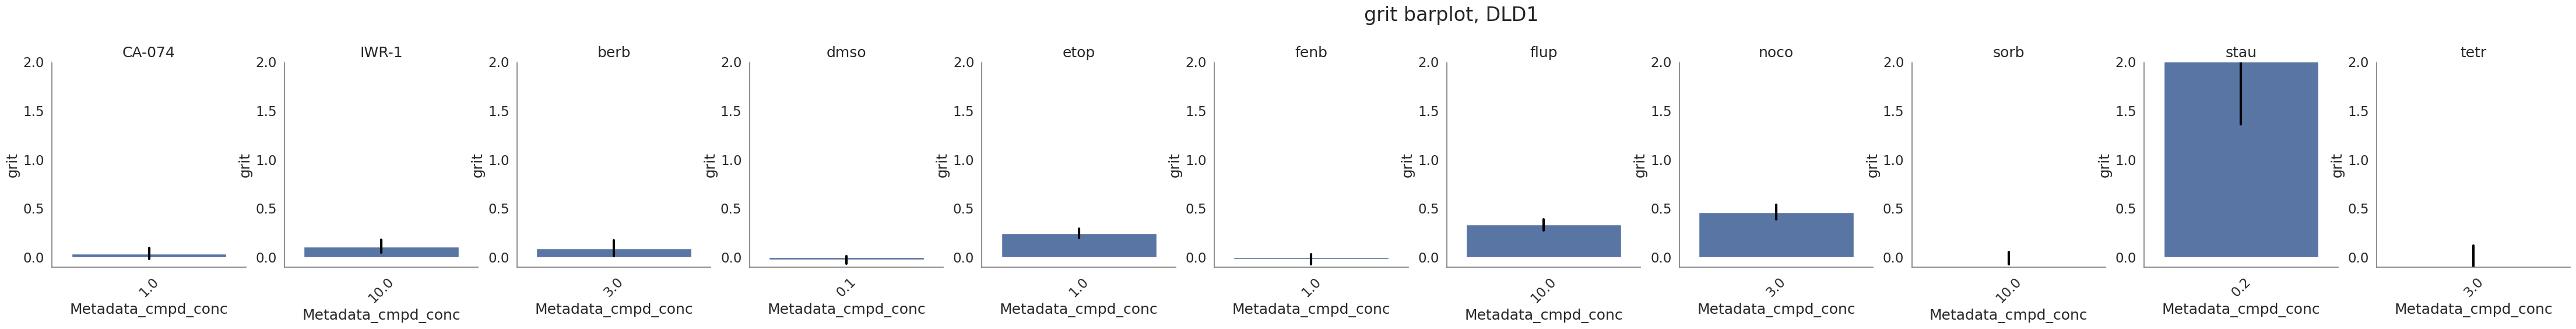

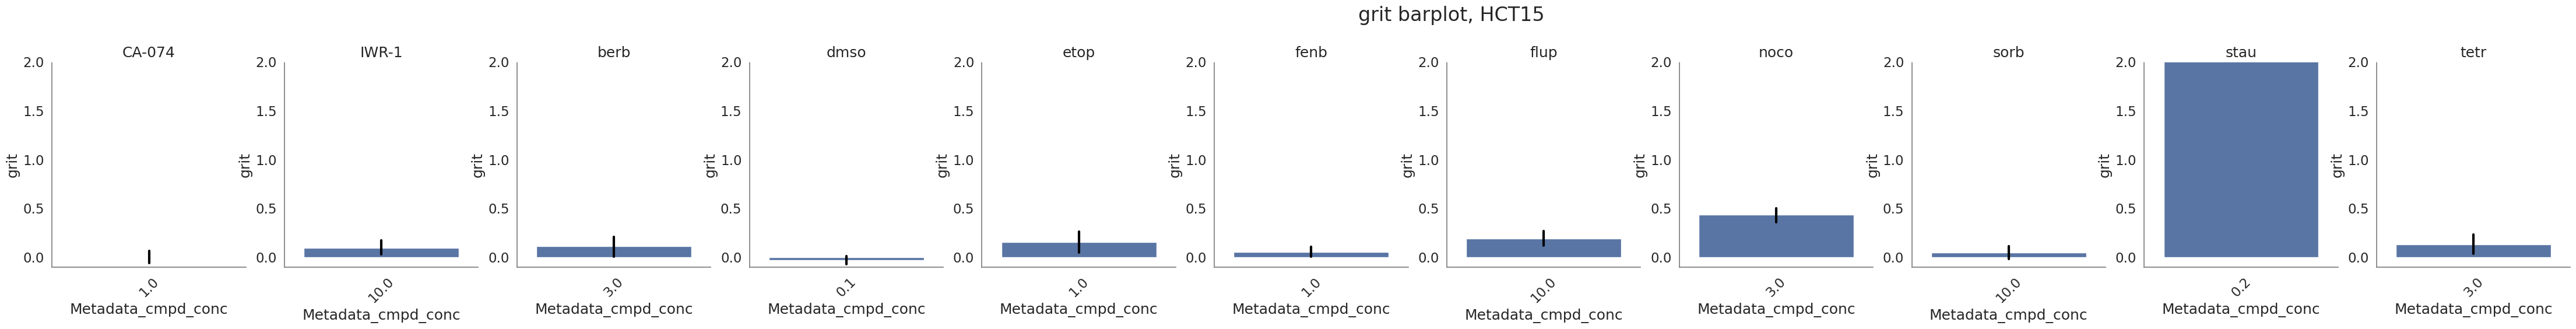

In [87]:
for cell_line in cells:

    fig = plt.figure(figsize=(48, 32))
    sns.set(font_scale=1.5)
    fig.suptitle("grit barplot, " + cell_line, fontsize=24, y=0.91)
    sp = 1
    nrrow = 6
    nrcol = 11

    CompoundsUsed = grit_scores["Metadata_cmpdname"].unique()
    for some in CompoundsUsed[:]:
        grit_scores_part = grit_scores[(grit_scores["Metadata_cmpdname"] == some) & (grit_scores["Metadata_cell_line"] == cell_line)].copy()
        grit_scores_part.sort_values(by="Metadata_cmpd_conc", inplace=True)
        ax = fig.add_subplot(nrrow, nrcol, sp)
        ax = sns.barplot(
            x="Metadata_cmpd_conc",
            y="grit",
            data=grit_scores_part,
            # palette="Blues_d",
            alpha=1,
            err_kws={'color': 'black', 'linewidth': 3},
            # errwidth=3,
        )
        ax.set_facecolor("w")
        ax.spines["bottom"].set_color("grey")
        ax.spines["left"].set_color("grey")
        ax.set_ylim([-0.1, 2])
        ax.set_title("{}".format(some))
        plt.subplots_adjust(wspace=0.2, hspace=0.2, left=0.0)
        plt.xticks(rotation = 45)
        sp += 1

    # fig.savefig(
    #         "{}/GritScores_{}.{}".format(OutputDir,cell_line,figformat), dpi=dpi, bbox_inches="tight"
    #         )

    plt.show()